In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from macrohet import visualise, dataio, tile
from tqdm.auto import tqdm
import os
import btrack
import json
import napari
import matplotlib as mpl
import matplotlib.patches as patches
import pickle
scale_factor = 6048/1200

# Function to calculate gradient for a window
def calculate_gradient(window):
    y = window
    x = np.arange(len(window))
    slope, _ = np.polyfit(x, y, 1)
    return slope

def find_doubling_points(time_values, mtb_values, min_mtb_value):
    # Check if any value doubles within the series
    for i in range(len(mtb_values)):
        q1 = mtb_values[i]
        t1 = time_values[i]
        
        # Skip if the mtb value is below the minimum threshold
        if q1 < min_mtb_value:
            continue
        
        for j in range(i + 1, len(mtb_values)):
            q2 = mtb_values[j]
            t2 = time_values[j]
            
            # Check if q2 is at least double q1
            if q2 >= 2 * q1:
                return t1, t2, q1, q2
    return None, None, None, None  # If no doubling is found

### Set style for plotting

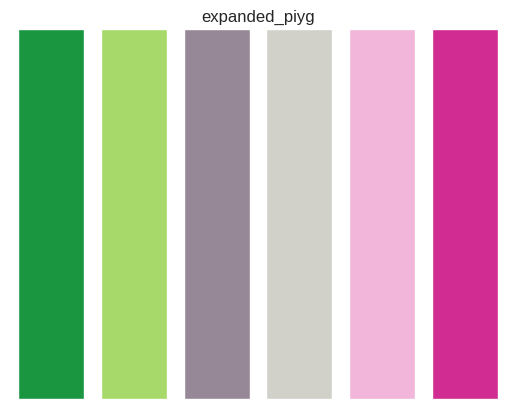

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [2]:
sns.set(style = 'white')

# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

### Load sc df

In [3]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_interp.pkl')
df['dMtb'] = df['delta Mtb max fold-change normalised max area']
df['Mtb'] = df['Intracellular thresholded Mtb content smooth']
# Assuming your DataFrame is named 'df'
df['Strain/Compound'] = df['Compound']  # Create a new column and copy values from 'Compound'
# Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
df.loc[df['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Strain,Compound,Concentration,Technical replicate,Cell ID,Acquisition ID,Unique ID,dMtb,Mtb,Strain/Compound
0,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
1,1,459.138947,6.718642,2314.060291,33.861954,0.0,1.0,0.0,16683.0,344.687042,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
2,2,460.555237,10.785886,2321.198394,54.360864,0.0,1.0,0.0,18935.0,343.875061,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
3,3,455.878815,11.143067,2297.629226,56.161059,1.0,1.0,0.0,19937.0,345.565796,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
4,4,462.634186,14.050420,2331.676296,70.814116,1.0,1.0,0.0,21793.0,350.585083,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296992,70,628.562500,1099.782104,3167.955000,5542.901807,1.0,0.0,1.0,101991.0,377.731873,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.031497,BDQ
296993,71,628.463684,1102.144409,3167.456968,5554.807822,1.0,0.0,1.0,100978.0,377.812103,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.274554,BDQ
296994,72,628.672058,1101.594727,3168.507173,5552.037422,1.0,0.0,1.0,108397.0,376.812805,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.220153,BDQ
296995,73,630.372803,1102.817749,3177.078926,5558.201455,1.0,0.0,1.0,107079.0,377.437073,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.002094,BDQ


### Calculate the maximum gradient for each cell

In [8]:
# df['Max. dMtb gradient'] = np.nan  # Initialize with NaN instead of None
for unique_ID in tqdm(df['Unique ID'].unique()):
    sc_df = df[df['Unique ID'] == unique_ID]

    max_gradient = sc_df['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).max()
    df.loc[df['Unique ID'] == unique_ID, 'Max. dMtb gradient'] = max_gradient
    if max_gradient > 120:
        print(unique_ID)

  0%|          | 0/3988 [00:00<?, ?it/s]

280.3.5
85.4.5


### Isolate the top ten fastest growers

In [9]:
N = 100
top_N_tracks = df.groupby('Unique ID')['Max. dMtb gradient'].max().sort_values(ascending=False).head(N)

## Plot an outlier

In [16]:
track_id = '264.4.6'

In [48]:
def find_doubling_points(time_values, mtb_values):
    # Check if any value doubles within the series
    for i in range(len(mtb_values)):
        q1 = mtb_values[i]
        t1 = time_values[i]
        for j in range(i+1, len(mtb_values)):
            q2 = mtb_values[j]
            t2 = time_values[j]
            # Check if q2 is at least double q1
            if q2 >= 2 * q1:
                return t1, t2, q1, q2
    return None, None, None, None  # If no doubling is found

# Example usage:
time_values = track_data['Time (hours)'].values  # Your existing time_values array
# mtb_values = track_data['Mtb'].values  # Your existing mtb_values array

t1, t2, q1, q2 = find_doubling_points(time_values, mtb_area)
if t1 is not None and t2 is not None:
    print(f"Found doubling from {q1} to {q2} between {t1} and {t2} hours")
else:
    print("No doubling found in the provided data.")

t2 - t1

Found doubling from 6089.2 to 12244.533333333333 between 14 and 64 hours


50

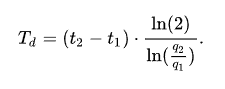

Found doubling from 6089.2 to 12244.533333333333 between 14 and 64 hours


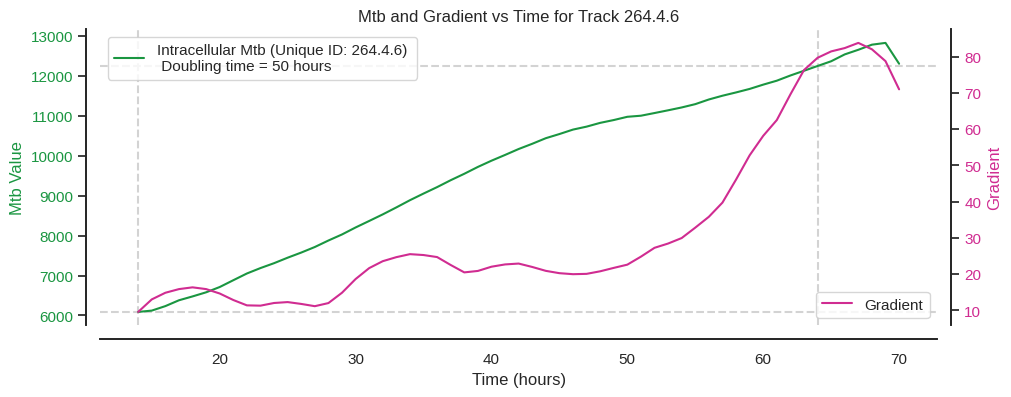

In [59]:
track_data = df[df['Unique ID'] == track_id]

# Convert to NumPy array for compatibility
time_values = track_data['Time (hours)'].values
mtb_values = track_data['Mtb'].values
mtb_area = pd.Series(mtb_areas_dict[track_id]).rolling(window=15).mean().values#.apply(calculate_gradient, raw=True).values #mtb_areas_dict[track_id] #
# gradient_values = track_data['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).values
gradient_values = track_data['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).values

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 4))

# plot doubling time
t1, t2, q1, q2 = find_doubling_points(time_values, mtb_area)
if t1 is not None and t2 is not None:
    print(f"Found doubling from {q1} to {q2} between {t1} and {t2} hours")
else:
    print("No doubling found in the provided data.")
# Overlay doubling time lines and annotations
for dt in [t1, t2]:
    ax1.axvline(x=dt, color='lightgrey', linestyle='--')
    # ax1.text(dt, max(mtb_area),)# f'{dt:.2f} h', rotation=45)
for dt in [q1, q2]:
    ax1.axhline(y=dt, color='lightgrey', linestyle='--')
    # ax1.text(0, max(time_values),)# f'{dt:.2f} h', rotation=45)

# Plot Mtb values
color = expanded_piyg[0]
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Mtb Value', color=color)
# ax1.plot(time_values, mtb_values, label=f'Intracellular Mtb (Unique ID: {track_id})', color=color)
ax1.tick_params(axis='y', labelcolor=color)
# for i in ['Intracellular mean Mtb content',
#        'Intracellular thresholded Mtb content',
#        'Intracellular thresholded Mtb content smooth']:
#     ax1.plot(time_values, track_data[i].values, label = i)
ax1.plot(time_values, mtb_area, label=f'Intracellular Mtb (Unique ID: {track_id}) \n Doubling time = {t2-t1} hours', color=color)

# Create a twin axis for the gradient
ax2 = ax1.twinx() 
color = expanded_piyg[-1]
ax2.set_ylabel('Gradient', color=color)  
ax2.plot(time_values, gradient_values, label='Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.title(f'Mtb and Gradient vs Time for Track {track_id}')
fig.tight_layout()
sns.despine(offset = 10, right = False)
plt.show()

### Calculating the doubling time of this growth

### What does this cell look like when the area of Mtb is plotted?

In [12]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/PS0000/'
metadata_path = os.path.join(base_dir, 'Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

In [13]:
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [8]:
tracks_dict = dict()
segmentation_dict = dict()

### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(f'/mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/{row,column}.h5', 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
        seg = reader.segmentation
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks
    segmentation_dict[(row, column)] = seg

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/11/27 12:14:11 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
[INFO][2023/11/27 12:14:11 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/11/27 12:14:11 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/11/27 12:14:11 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/11/27 12:14:24 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/11/27 12:14:24 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
[INFO][2023/11/27 12:14:24 PM] Opening HDF file: /mnt/DATA/macrohet/labels/P

In [9]:
# Initialize a dictionary to store Mtb area values
mtb_areas_dict = {}

for i, track_id in tqdm(enumerate(top_N_tracks.keys()), total=len(top_N_tracks)):
    # measuring the area of Mtb from the images... 
    track_data = df[df['Unique ID'] == track_id]
    
    # get acq ID and ID from track id'
    acq_ID = track_data['Acquisition ID'].iloc[0]
    cell_ID = track_data['Cell ID'].iloc[0]
    row, column = acq_ID
    image_dir = os.path.join(base_dir, 'Images')
    
    masks = segmentation_dict[acq_ID]
    mtb_areas = []
    # obtain mask information 
    for df_row in tqdm(track_data.iterrows(), total=len(track_data),
                        desc=f'Extracting measurements over each frame: {acq_ID, cell_ID}'):
        # get coords
        t, y, x = df_row[1]['Time (hours)'], int(df_row[1]['y']), int(df_row[1]['x'])
        y, x = int(y*scale_factor), int(x*scale_factor)
        # select proper frame
        frame = masks[t, ...]
        # check to see if mask exists
        if frame[y, x]:
            # select cell of interest
            mask = frame == frame[y, x]
            images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, column, 
                                 set_plane='max_proj',
                                 set_channel=2,
                                 set_time = t,
    #                             input_transforms = [input_transforms]
                                )[0,0].compute().compute()
            masked_image = images*mask 
            thresholded_masked_image = masked_image >=480
            mtb_area = np.sum(thresholded_masked_image)
            mtb_areas.append(mtb_area)
        else:
            mtb_areas.append(0)  # Append 0 if no mask exists
            
    mtb_areas_dict[track_id] = mtb_areas

# Now, create a new column 'Mtb Area' in df
# For each row in df, find the mtb_area from the dictionary using 'Unique ID'
df['Mtb Area'] = df['Unique ID'].apply(lambda id: mtb_areas_dict.get(id, 0))

  0%|          | 0/100 [00:00<?, ?it/s]

Extracting measurements over each frame: ((3, 5), 280):   0%|          | 0/74 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 36) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 37) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 38) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 39) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 40) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 41) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 42) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 43) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 44) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 45) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 46) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 47) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 48) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 49) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 50) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 51) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 52) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 53) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 54) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 55) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 56) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 57) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 58) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 59) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 60) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 61) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 62) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 64) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 66) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 67) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 68) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 69) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 70) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 71) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 72) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 5, 'max_proj', 2, 74) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting measurements over each frame: ((4, 5), 85):   0%|          | 0/75 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 32) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 36) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 37) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 38) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 39) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 40) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 41) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 42) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 43) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 44) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 45) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 46) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 47) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 48) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 49) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 50) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 51) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 52) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 53) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 54) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 55) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 56) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 57) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 58) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 59) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 60) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 61) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 62) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 63) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 64) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 65) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 66) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 67) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 68) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 69) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 70) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 71) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 72) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 73) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 74) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting measurements over each frame: ((5, 6), 375):   0%|          | 0/75 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 32) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 36) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 37) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 38) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 39) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 40) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 41) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 42) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 43) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 44) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 45) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 46) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 47) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 48) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 49) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 50) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 51) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 52) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 53) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 55) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 56) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 57) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 58) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 59) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 60) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 61) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 62) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 63) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 64) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 65) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 66) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 67) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 68) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 69) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 70) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 71) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 72) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 73) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 6, 'max_proj', 2, 74) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting measurements over each frame: ((6, 5), 1092):   0%|          | 0/71 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 32) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 36) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 37) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 38) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 39) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 40) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 41) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 42) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 43) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 44) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 45) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 46) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 47) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 48) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 49) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 50) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 51) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 52) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 53) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 54) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 55) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 56) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 57) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 58) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 59) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 60) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 61) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 62) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 63) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 64) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 65) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 66) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 67) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 68) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 69) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 70) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 71) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 72) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 73) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (6, 5, 'max_proj', 2, 74) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting measurements over each frame: ((5, 5), 381):   0%|          | 0/75 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 32) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 37) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 38) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 40) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 41) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 42) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 43) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 45) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 46) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 47) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 48) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 50) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 51) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 52) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 53) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 54) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 55) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 56) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 57) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 58) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 59) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 60) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 61) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 62) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 63) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 64) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 65) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 66) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 67) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 68) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 69) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 70) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 71) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 72) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 73) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', 2, 74) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting measurements over each frame: ((4, 6), 264):   0%|          | 0/71 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 32) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 36) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 37) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 38) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 39) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 40) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 41) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 42) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 43) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 44) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 45) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 46) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 47) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 48) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 49) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 50) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 51) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 52) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 53) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 54) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 55) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 56) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 57) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 58) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 59) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 60) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 61) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 62) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 63) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 64) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 65) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 66) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 67) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 68) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 69) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 6, 'max_proj', 2, 70) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting measurements over each frame: ((4, 5), 11):   0%|          | 0/71 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 32) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 36) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 37) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 38) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 39) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 40) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 41) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 42) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 43) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 44) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 45) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 46) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 47) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 48) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 49) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 50) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 51) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 52) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 53) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 54) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 55) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 56) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 57) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 58) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 59) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 60) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 61) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 62) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 63) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 64) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 65) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 66) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 67) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 68) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 69) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 70) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting measurements over each frame: ((3, 8), 671):   0%|          | 0/74 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 32) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 36) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 37) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 38) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 39) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 40) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 41) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 42) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 43) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 44) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 45) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 46) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 47) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 48) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 49) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 50) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 51) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 52) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 53) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 54) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 55) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 56) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 57) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 58) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 59) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 60) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 61) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 62) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 63) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 64) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 65) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 66) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 67) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 68) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 69) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 70) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 71) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 72) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 8, 'max_proj', 2, 73) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting measurements over each frame: ((4, 5), 118):   0%|          | 0/75 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 5) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (4, 5, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt



In [67]:
min_mtb_area = 100

  0%|          | 0/100 [00:00<?, ?it/s]

Found doubling from 153.66666666666666 to 327.0 between 29 and 46 hours


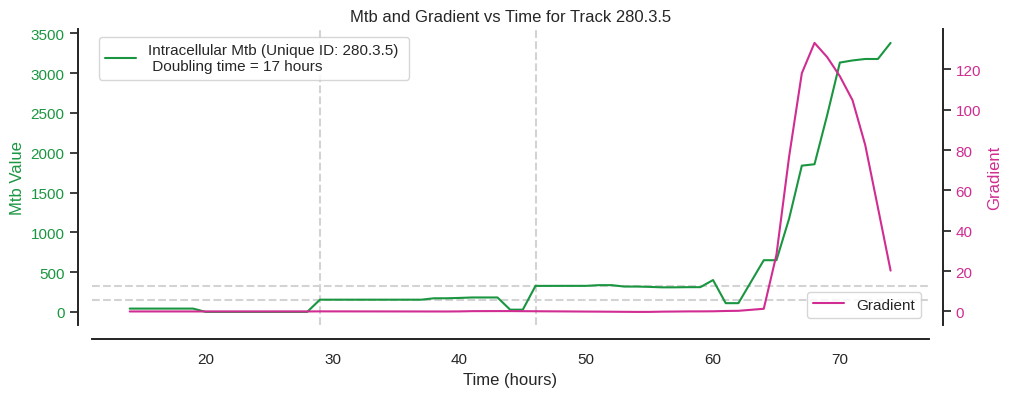

Found doubling from 2648.9333333333334 to 5304.066666666667 between 14 and 43 hours


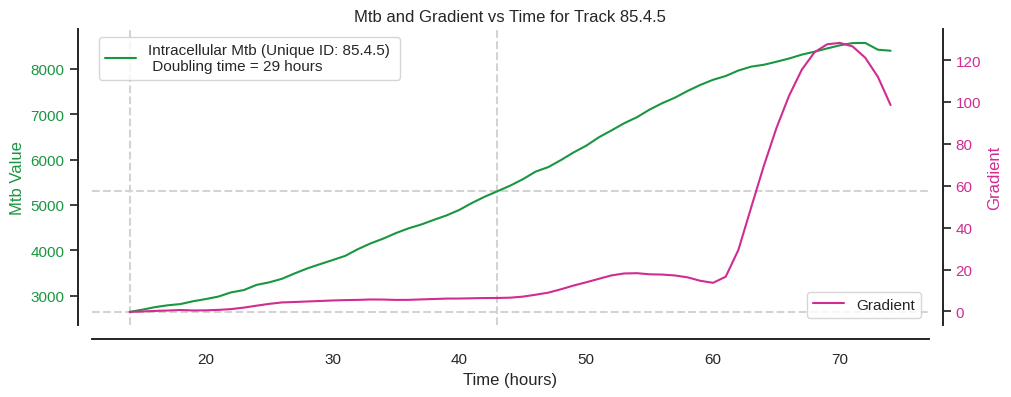

No doubling found in the provided data.


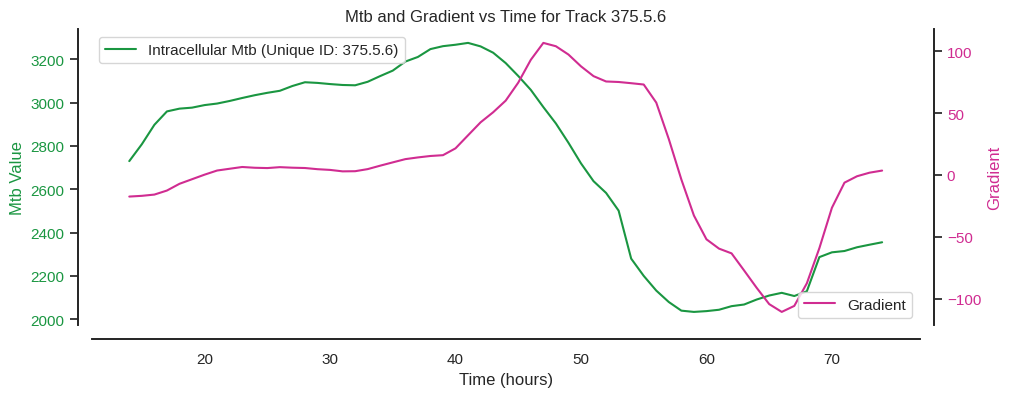

Found doubling from 1072.9333333333334 to 2271.8 between 18 and 71 hours


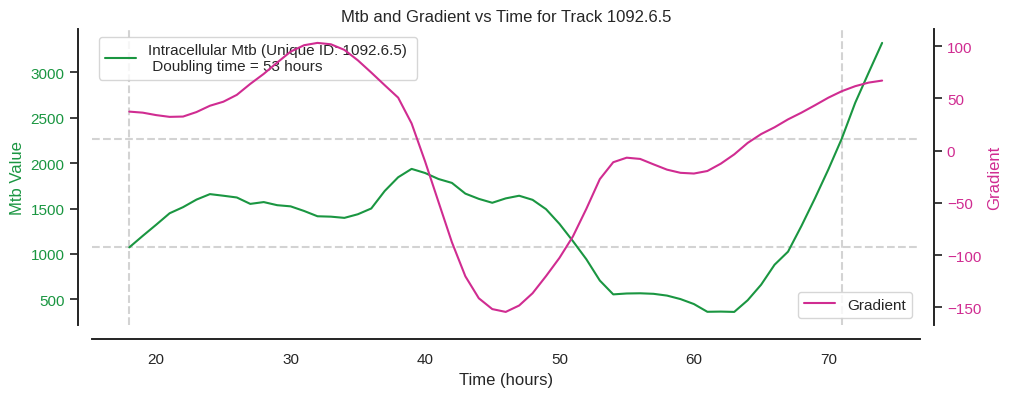

Found doubling from 2546.6666666666665 to 5430.933333333333 between 14 and 33 hours


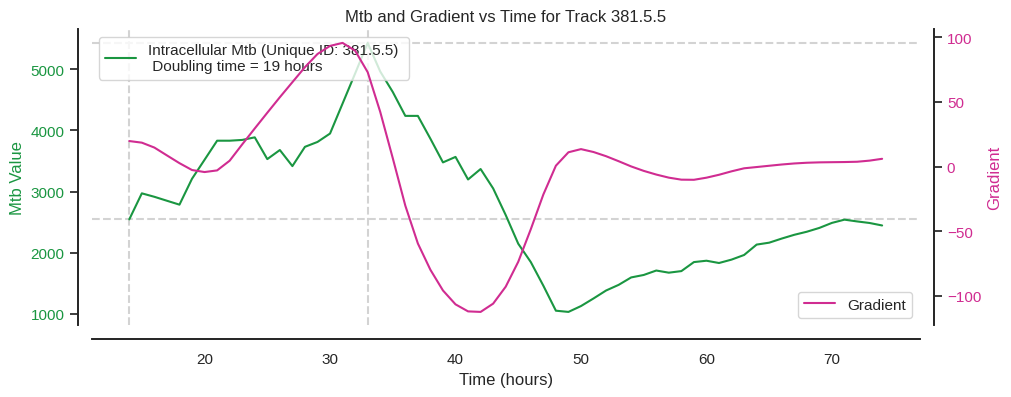

Found doubling from 6089.2 to 12244.533333333333 between 14 and 64 hours


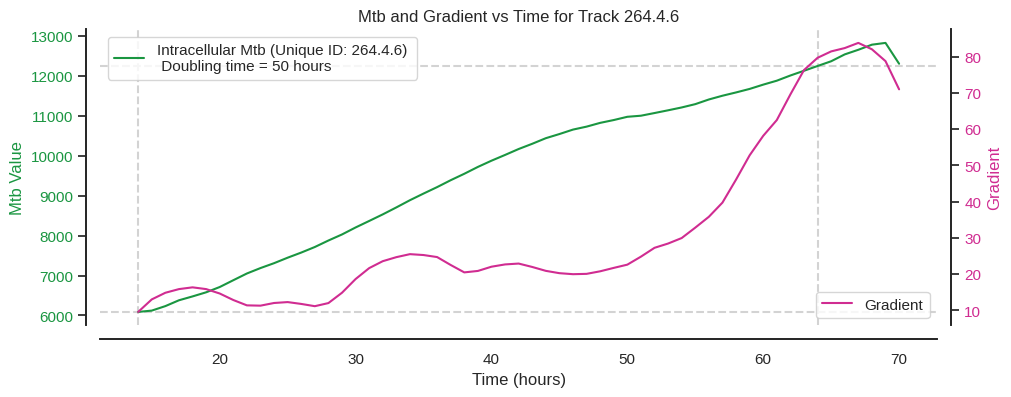

Found doubling from 130.93333333333334 to 494.93333333333334 between 62 and 63 hours


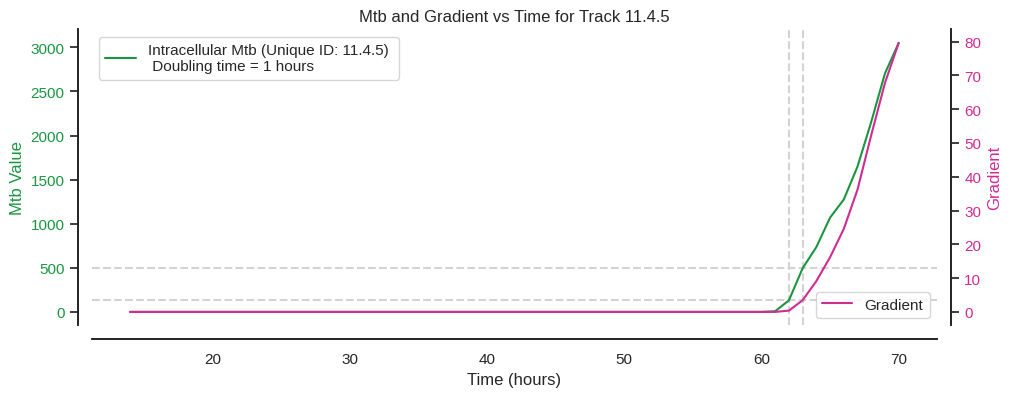

Found doubling from 1912.7333333333333 to 3831.0666666666666 between 14 and 29 hours


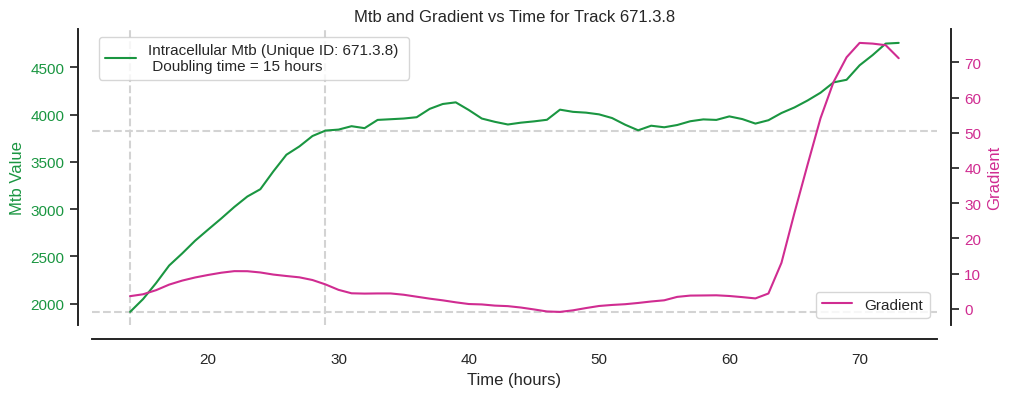

Found doubling from 2712.866666666667 to 5524.666666666667 between 14 and 42 hours


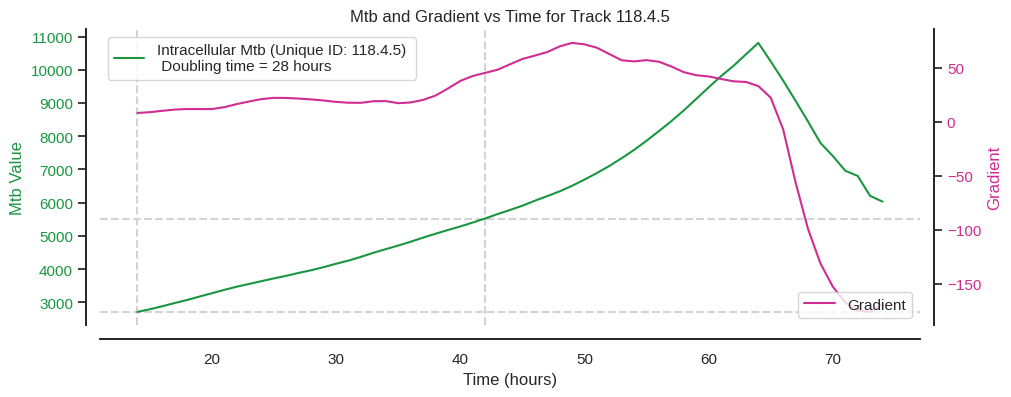

Found doubling from 3150.0666666666666 to 6315.666666666667 between 18 and 47 hours


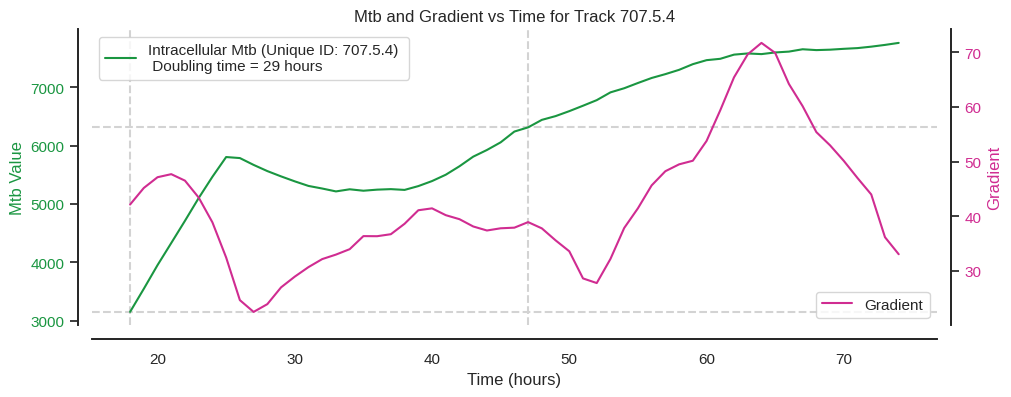

Found doubling from 4213.466666666666 to 8445.6 between 14 and 54 hours


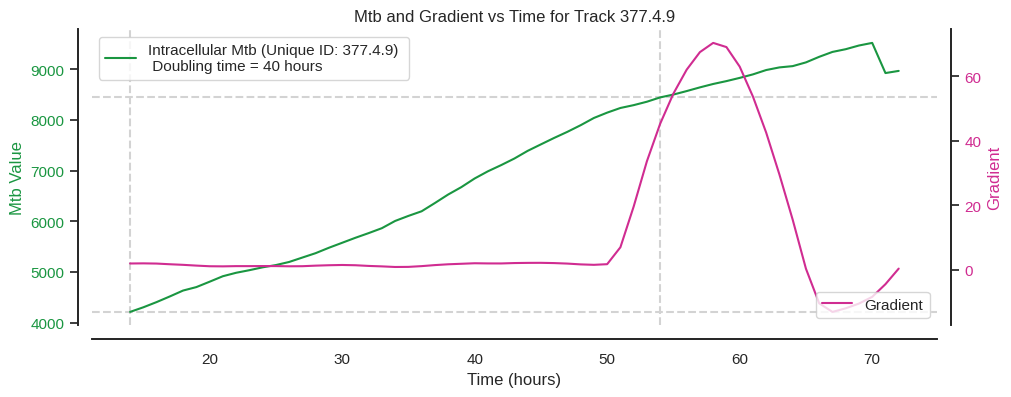

Found doubling from 220.93333333333334 to 544.2666666666667 between 62 and 63 hours


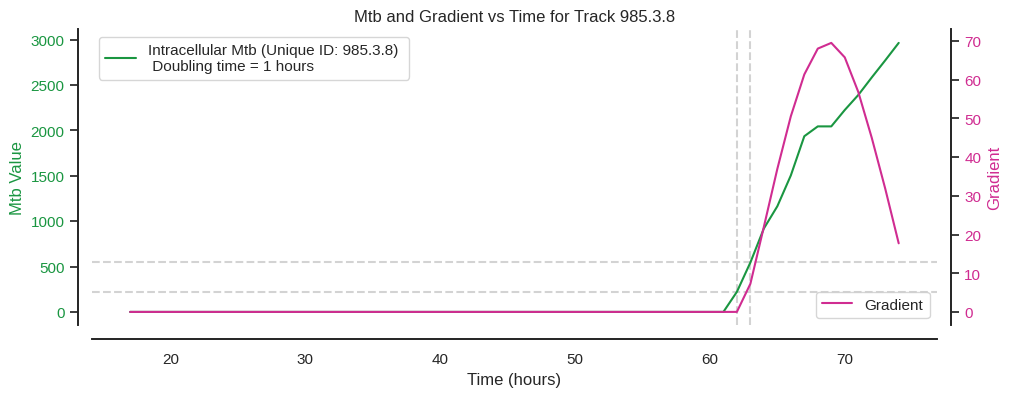

Found doubling from 268.0 to 563.0666666666667 between 14 and 21 hours


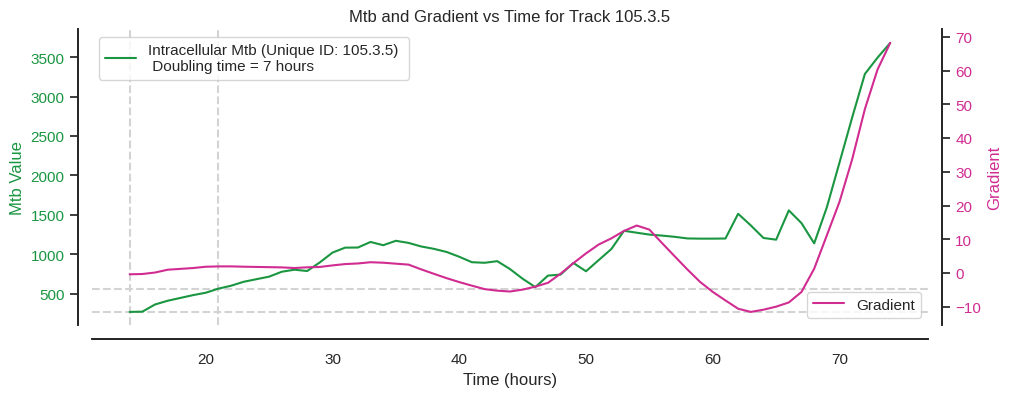

Found doubling from 3150.4666666666667 to 6580.866666666667 between 14 and 32 hours


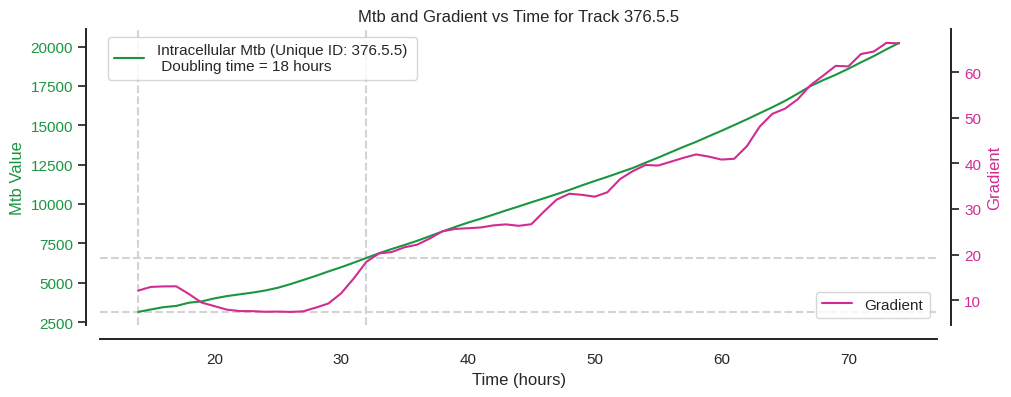

Found doubling from 1376.0 to 2766.6 between 14 and 29 hours


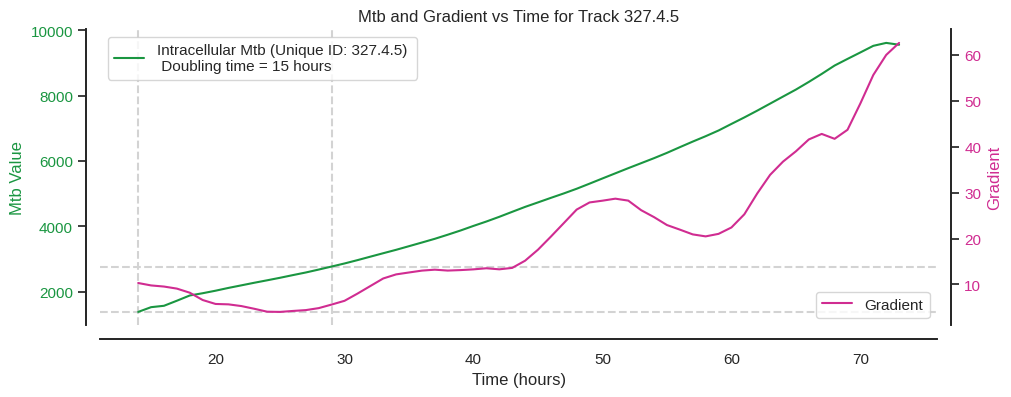

Found doubling from 2380.5333333333333 to 4830.266666666666 between 14 and 40 hours


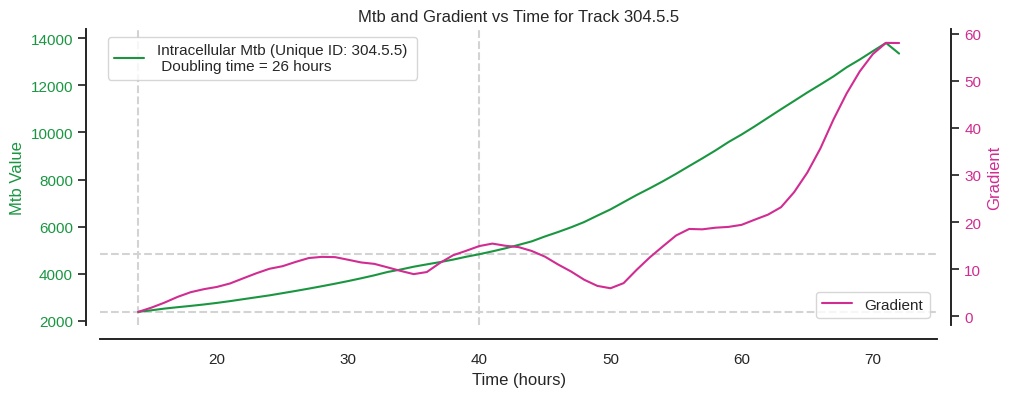

Found doubling from 2524.733333333333 to 5127.466666666666 between 14 and 37 hours


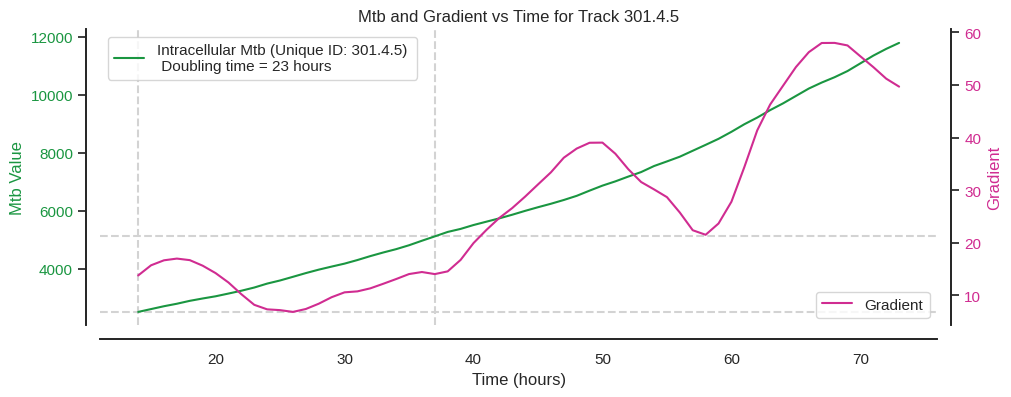

Found doubling from 311.4 to 644.7333333333333 between 46 and 48 hours


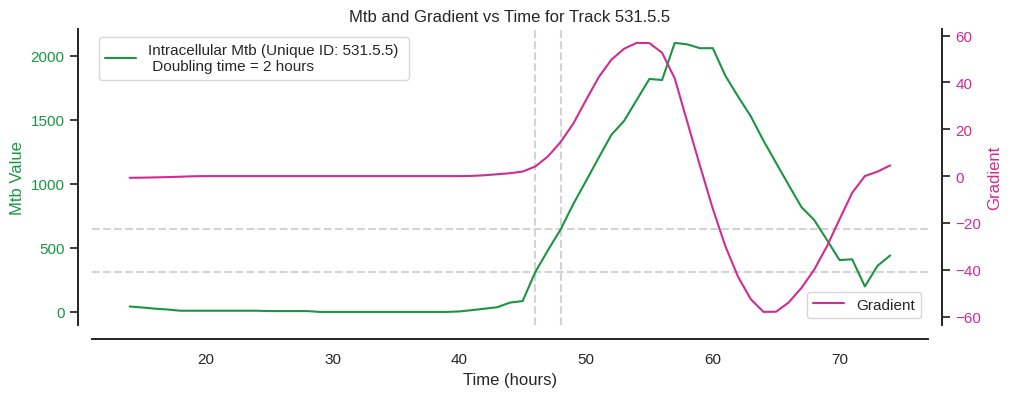

No doubling found in the provided data.


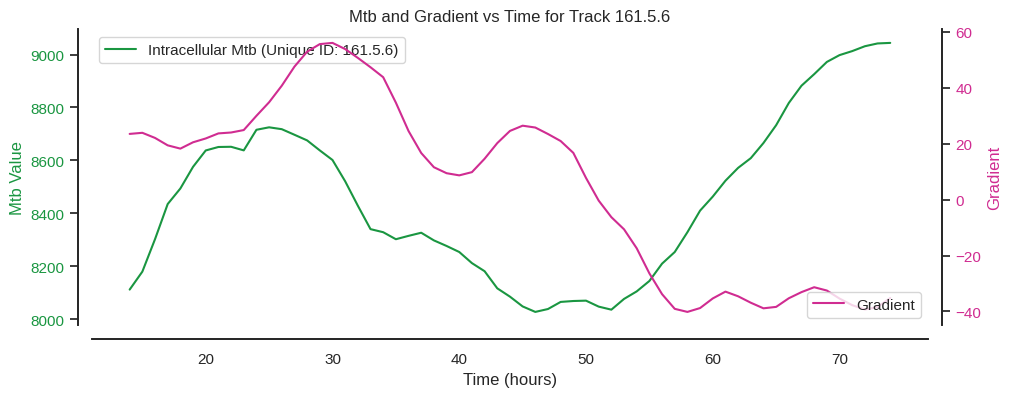

No doubling found in the provided data.


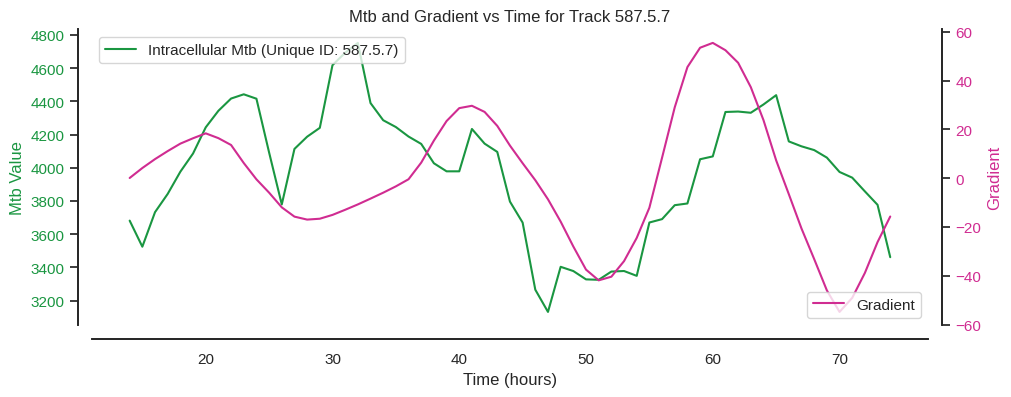

Found doubling from 1984.1333333333334 to 4103.466666666666 between 14 and 39 hours


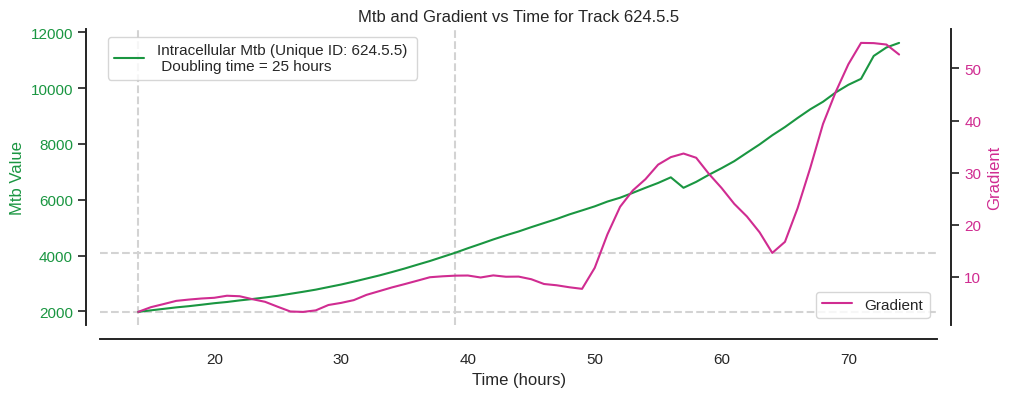

Found doubling from 117.93333333333334 to 298.8666666666667 between 32 and 40 hours


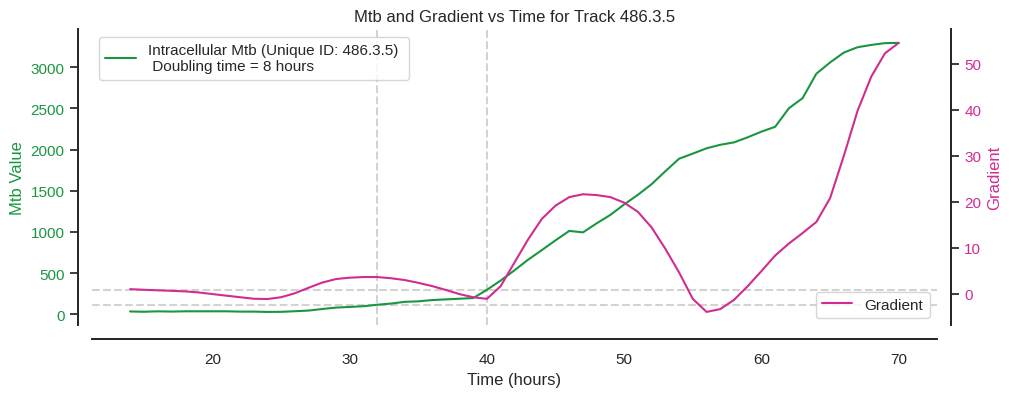

Found doubling from 552.0666666666667 to 1213.0666666666666 between 16 and 24 hours


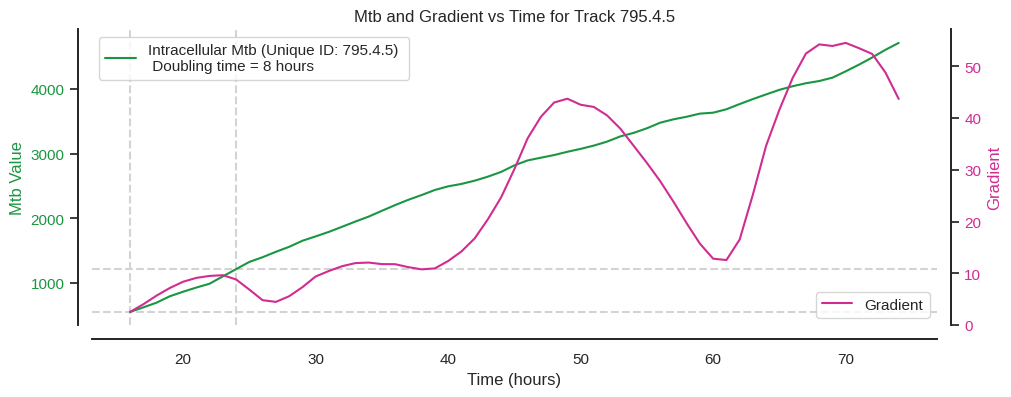

Found doubling from 1967.9333333333334 to 3970.3333333333335 between 14 and 33 hours


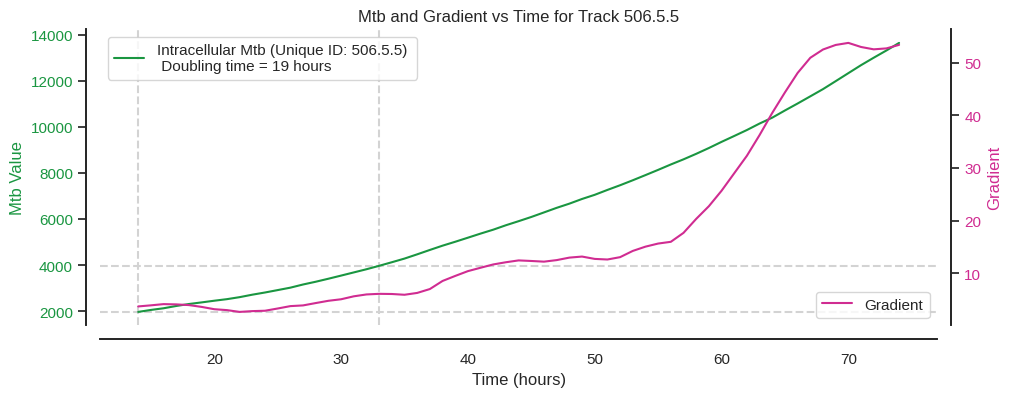

Found doubling from 1056.7333333333333 to 2166.6666666666665 between 14 and 38 hours


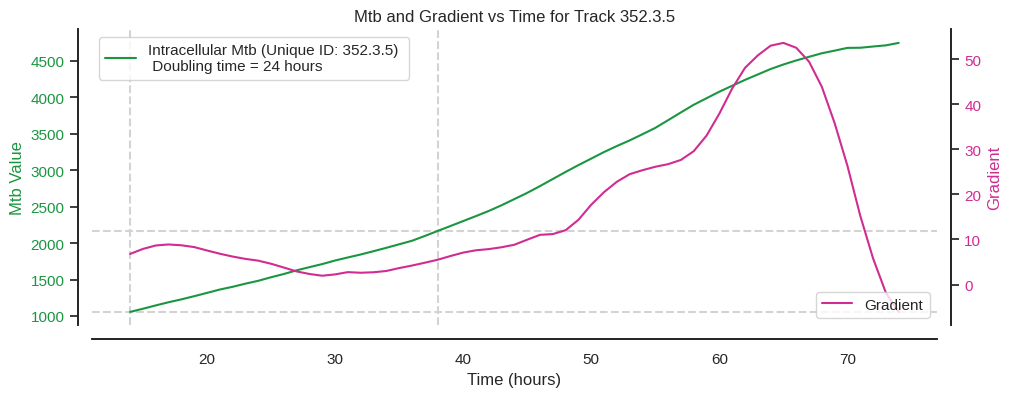

Found doubling from 220.86666666666667 to 874.8 between 14 and 57 hours


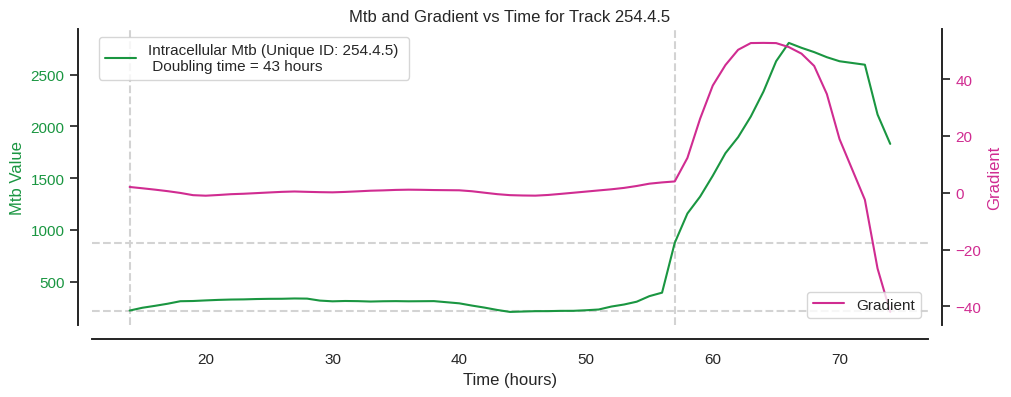

Found doubling from 1139.8 to 2307.2 between 14 and 33 hours


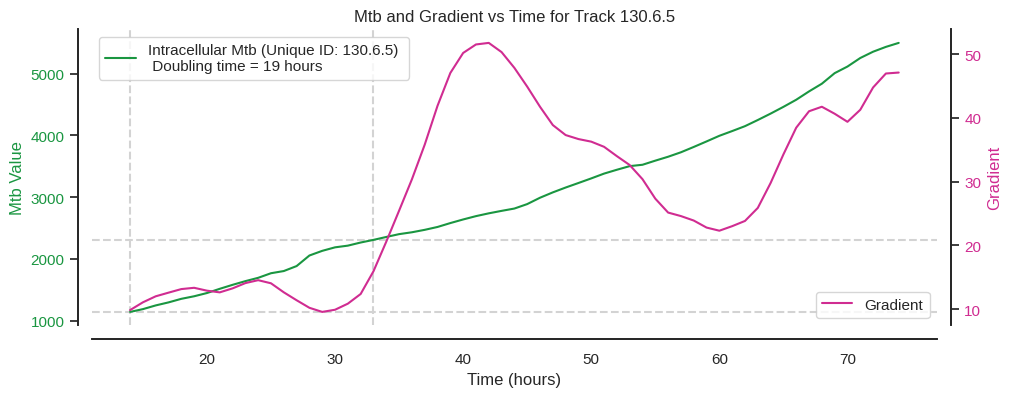

No doubling found in the provided data.


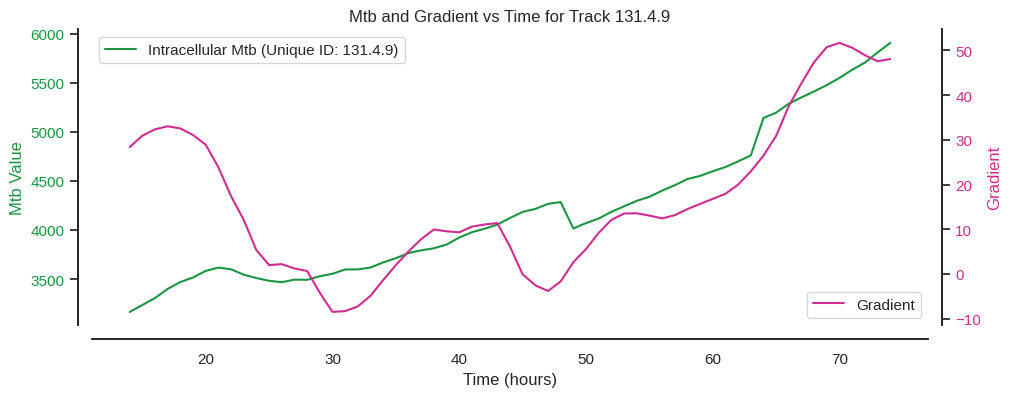

Found doubling from 886.3333333333334 to 1800.4666666666667 between 15 and 37 hours


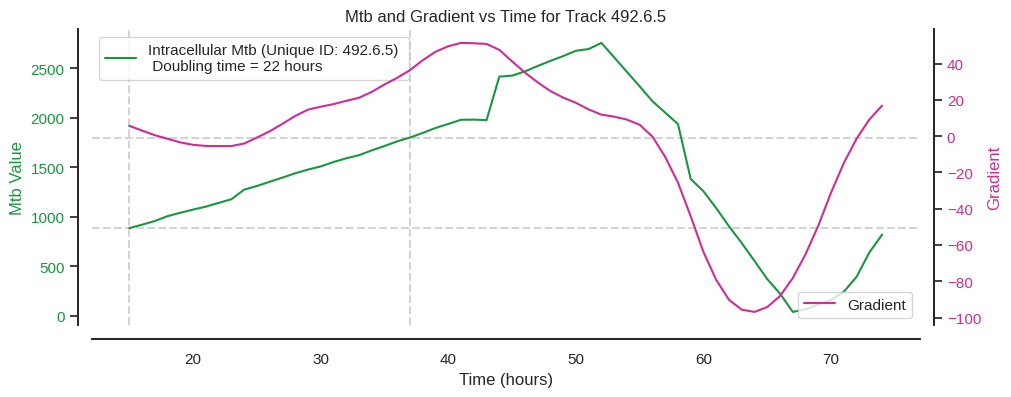

In [70]:
for i, track_id in tqdm(enumerate(top_N_tracks.keys()), total=len(top_N_tracks)):
    if track_id not in mtb_areas_dict.keys():
        continue
    track_data = df[df['Unique ID'] == track_id]

    # Convert to NumPy array for compatibility
    time_values = track_data['Time (hours)'].values
    mtb_values = track_data['Mtb'].values
    mtb_area = pd.Series(mtb_areas_dict[track_id]).rolling(window=15).mean().values#.apply(calculate_gradient, raw=True).values #mtb_areas_dict[track_id] #
    # gradient_values = track_data['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).values
    gradient_values = track_data['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).values
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # plot doubling time
    t1, t2, q1, q2 = find_doubling_points(time_values, mtb_area, min_mtb_area)
    if t1 is not None and t2 is not None:
        print(f"Found doubling from {q1} to {q2} between {t1} and {t2} hours")
        # Overlay doubling time lines and annotations
        for dt in [t1, t2]:
            ax1.axvline(x=dt, color='lightgrey', linestyle='--')
            # ax1.text(dt, max(mtb_area),)# f'{dt:.2f} h', rotation=45)
        for dt in [q1, q2]:
            ax1.axhline(y=dt, color='lightgrey', linestyle='--')
            # ax1.text(0, max(time_values),)# f'{dt:.2f} h', rotation=45)
        ax1label = f'Intracellular Mtb (Unique ID: {track_id}) \n Doubling time = {t2-t1} hours'
    else:
        print("No doubling found in the provided data.")
        ax1label = f'Intracellular Mtb (Unique ID: {track_id})'
    
    
    # Plot Mtb values
    color = expanded_piyg[0]
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Mtb Value', color=color)
    # ax1.plot(time_values, mtb_values, label=f'Intracellular Mtb (Unique ID: {track_id})', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    # for i in ['Intracellular mean Mtb content',
    #        'Intracellular thresholded Mtb content',
    #        'Intracellular thresholded Mtb content smooth']:
    #     ax1.plot(time_values, track_data[i].values, label = i)
    ax1.plot(time_values, mtb_area, label=ax1label, color=color)
    
    # Create a twin axis for the gradient
    ax2 = ax1.twinx() 
    color = expanded_piyg[-1]
    ax2.set_ylabel('Gradient', color=color)  
    ax2.plot(time_values, gradient_values, label='Gradient', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')
    
    plt.title(f'Mtb and Gradient vs Time for Track {track_id}')
    fig.tight_layout()
    sns.despine(offset = 10, right = False)
    plt.show()

In [11]:
# Save the dictionary to a file

with open('mtb_areas_dict.pkl', 'wb') as file:
        pickle.dump(mtb_areas_dict, file)

In [69]:
with open('mtb_areas_dict.pkl', 'rb') as file:
    mtb_areas_dict = pickle.load(file)